Update :
    Ajout de couches de décision

In [22]:
import random

import keras
import re
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D,Dense
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dropout, Lambda
from keras.layers import concatenate
import glob

## Load model

In [23]:
model = keras.models.load_model('A:\\fingers.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [24]:
x = model.layers[-2].output

In [25]:
x

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'global_average_pooling2d')>

In [26]:
x = Dense(units=128, activation='relu')(x)
output = Dense(units=3, activation='softmax')(x)

In [27]:
model = Model(inputs=model.input, outputs=output)

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

## Load Data

In [29]:
from tqdm import tqdm
import random
def load(set: str):
    xtrain = []
    ytrain = []
    print(set)
    train_num_files = 0
    for source in ["Temps1", "Temps2", "Temps3"]:
        print(source)
        file_list = glob.glob(
            r"A:/%(s)s/images/%(set)s/*.png" % {"s": source, "set": set})
        if source == "Temps0":
            file_list = random.choices(file_list, k=200)
        # print(len(file_list))
        for file in tqdm(file_list, desc="Loading..."):
            p = 'A:/%(s)s/labels/%(set)s/' % {"s": source, "set": set}
            file_label = p + file[len(p):]
            file_label = file_label[:-4]
            file_label = file_label+'.txt'
            if os.path.isfile(file_label):
                f = open(file_label,"r+")
                a = f.read()
                if len(a)>=1:
                    im = imread(file)[:, :, :3]
                    train_num_files += 1
                    xtrain.append(im)
                    ytrain.append([int(a[0])])
                f.close()
    return xtrain, ytrain

xtrain, ytrain = load("train")
xval, yval = load("val")
xtest, ytest = load("test")
# xtest2, ytest2 = load("train", mode="choices", k=200, sources=("Temps0",))

train
Temps1


Loading...: 100%|██████████| 519/519 [00:01<00:00, 502.29it/s]


Temps2


Loading...: 100%|██████████| 448/448 [00:01<00:00, 432.33it/s]


Temps3


Loading...: 100%|██████████| 326/326 [00:00<00:00, 415.33it/s]


val
Temps1


Loading...: 100%|██████████| 54/54 [00:00<00:00, 416.53it/s]


Temps2


Loading...: 100%|██████████| 310/310 [00:00<00:00, 412.79it/s]


Temps3


Loading...: 100%|██████████| 71/71 [00:00<00:00, 337.39it/s]


test
Temps1


Loading...: 100%|██████████| 31/31 [00:00<00:00, 275.07it/s]


Temps2


Loading...: 100%|██████████| 321/321 [00:00<00:00, 410.00it/s]


Temps3


Loading...: 100%|██████████| 181/181 [00:00<00:00, 399.72it/s]


In [30]:
filepath = 'shifumi_from_mobil.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_f1_score',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [31]:
def f1_score(y_true, y_pred):
	def recall_m(y_true, y_pred):
		TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

		recall = TP / (Positives+K.epsilon())
		return recall


	def precision_m(y_true, y_pred):
		TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

		precision = TP / (Pred_Positives+K.epsilon())
		return precision

	precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

	return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [33]:
from keras.utils import to_categorical

In [34]:
xtrain = np.asarray(xtrain)
xval = np.asarray(xval)
xtest = np.asarray(xtest)
ytrain = to_categorical(ytrain)
yval = to_categorical(yval)
ytest = to_categorical(ytest)

## Data augmentation

In [35]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=60,
    width_shift_range=0.2,
	height_shift_range=0.2,
	# brightness_range=(-1, 1),
	zoom_range=(0.33,1.3),
    horizontal_flip=True,
    # validation_split=0.1
)

In [36]:
random.seed(42)
datagen.fit(xtrain)

In [37]:
plt.imshow(datagen.random_transform(xtrain[350], seed=42))

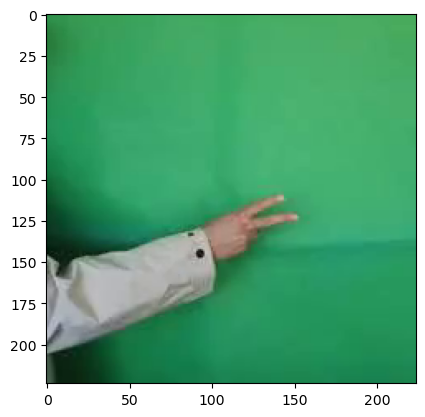

In [38]:
plt.imshow(xtrain[350])

In [39]:
import sys
sys.getsizeof(xtrain)

777326744

## Train

In [40]:

history = model.fit(datagen.flow(xtrain, ytrain, batch_size=10),
		  # model.fit(train_gen,
		  validation_data=datagen.flow(xval, yval, batch_size=10),
		  batch_size=10,
		  steps_per_epoch=len(xtrain) // 10,
		  epochs=10, verbose=1, callbacks=callbacks)

Epoch 1/10
129/129 [==============================] - ETA: 0s - loss: 0.8829 - accuracy: 0.6097 - f1_score: 0.5777
Epoch 1: val_f1_score improved from -inf to 0.57517, saving model to shifumi_from_mobil.hdf5
129/129 [==============================] - 19s 133ms/step - loss: 0.8829 - accuracy: 0.6097 - f1_score: 0.5777 - val_loss: 0.9472 - val_accuracy: 0.5816 - val_f1_score: 0.5752
Epoch 2/10
129/129 [==============================] - ETA: 0s - loss: 0.5730 - accuracy: 0.7611 - f1_score: 0.7553
Epoch 2: val_f1_score improved from 0.57517 to 0.64100, saving model to shifumi_from_mobil.hdf5
129/129 [==============================] - 16s 125ms/step - loss: 0.5730 - accuracy: 0.7611 - f1_score: 0.7553 - val_loss: 1.0101 - val_accuracy: 0.6391 - val_f1_score: 0.6410
Epoch 3/10
129/129 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.8103 - f1_score: 0.8005
Epoch 3: val_f1_score did not improve from 0.64100
129/129 [==============================] - 15s 117ms/step - los

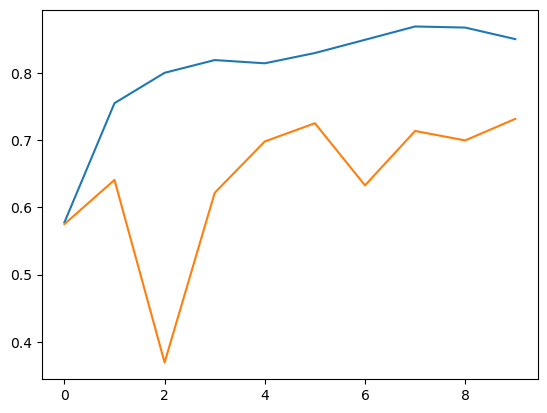

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history["f1_score"])
plt.plot(history.history["val_f1_score"])
plt.show()

In [43]:
callbacks[0].model.evaluate(xtest, ytest)

17/17 [==============================] - 1s 32ms/step - loss: 0.5925 - accuracy: 0.7749 - f1_score: 0.7751


[0.5925152897834778, 0.7748593091964722, 0.7750868797302246]